In [20]:
import os
import pandas as pd
import numpy as np

import csv
import glob

combined_data = {}

metric_targets = [ "inst_per_warp","dram_read_transactions", 
                  "gld_throughput", "l2_write_transactions",
                  "warp_nonpred_execution_efficiency",
                  "l2_tex_read_hit_rate","ipc",
                 "l2_tex_write_transactions","l2_read_transactions",
                 "inst_per_warp","shared_store_transactions",
                 "shared_load_transactions","gld_transactions","global_hit_rate",
                 "dram_write_throughput","tex_cache_throughput","l2_tex_read_throughput",
                 "l2_tex_write_throughput","l2_read_throughput","l2_write_throughput"]
bench_targets = [ "gaussian" ,"gemm" ]

for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_results/*.csv"):
    
    filen = os.path.basename(filen_)
    
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        
        for line_split in fdata:
            
            lsplt = (len(line_split) > 0)

            if data_found:
                
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    mname_index = index_lookup['Metric Name']
                    metric_name = line_split[ mname_index ]
                    if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0

                    # integer value
                    if metric_name in ["l2_tex_write_transactions","shared_store_transactions","shared_load_transactions",
                                      "gld_transactions","l2_read_transactions","l2_write_transactions","dram_read_transactions"]:
                        value = int(line_split[ target_index ])
                        
                    # Labeled with percentage
                    elif metric_name in [ "warp_nonpred_execution_efficiency","l2_tex_read_hit_rate","global_hit_rate" ]:
                        # Just take the first 7 chars and convert to fraction
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif metric_name in [ "write", "read", "gld_throughput","dram_write_throughput","tex_cache_throughput",
                                        "l2_tex_read_throughput","l2_tex_write_throughput","l2_read_throughput","l2_write_throughput"]:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # otherwise, float
                    else:
                        value = float(line_split[ target_index ])
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data): 
                        combined_data [ key ] = {}
                        combined_data [ key ][ 'size' ] = int( size_str )
                    
                    # Store value for the metric being read right now
                    combined_data [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                    
#print(combined_data)

                                    size  inst_per_warp  \
gemm_10112_sgemm_128x128x8_NN_vec  10112  726342.000000   
gemm_10240_sgemm_128x128x8_NN_vec  10240  735526.000000   
gemm_1024_maxwell_sgemm_128x64_nn   1024   38856.096094   
gemm_10368_sgemm_128x128x8_NN_vec  10368  744710.000000   
gemm_1152_maxwell_sgemm_128x64_nn   1152   29509.467284   

                                   warp_nonpred_execution_efficiency  \
gemm_10112_sgemm_128x128x8_NN_vec                           0.991180   
gemm_10240_sgemm_128x128x8_NN_vec                           0.991181   
gemm_1024_maxwell_sgemm_128x64_nn                           0.995702   
gemm_10368_sgemm_128x128x8_NN_vec                           0.991183   
gemm_1152_maxwell_sgemm_128x64_nn                           0.994771   

                                   shared_store_transactions  \
gemm_10112_sgemm_128x128x8_NN_vec                  508466752   
gemm_10240_sgemm_128x128x8_NN_vec                  527974400   
gemm_1024_maxwell_sg

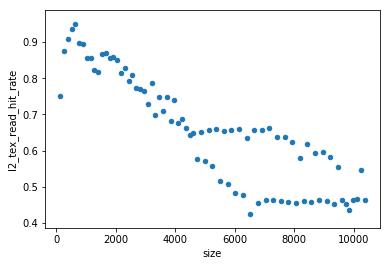

In [21]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data,orient="index")
print (df.head())

df.plot(x='size', y='l2_tex_read_hit_rate', kind='scatter')

## Going through all metrics to check whether significant (not 0) 

In [124]:
import numbers
combined_data_ = {}

metric_targets = []
all_sig_metrics = []
bench_targets = [ "gaussian" ,"gemm" ]
for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_results/*.csv"):
    filen = os.path.basename(filen_)
    
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        
        for line_split in fdata:
            
            lsplt = (len(line_split) > 0)

            if data_found:
                
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                        combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)
print(combined_data_)

{'gemm_128_sgemm_32x32x32_NN_vec': {'size': 128, 'inst_per_warp': 1665.0, 'branch_efficiency': 1.0, 'warp_execution_efficiency': 1.0, 'warp_nonpred_execution_efficiency': 0.963363, 'inst_replay_overhead': 0.001824, 'shared_load_transactions_per_request': 1.473684, 'shared_store_transactions_per_request': 1.970149, 'local_load_transactions_per_request': 0.0, 'local_store_transactions_per_request': 0.0, 'gld_transactions_per_request': 8.0, 'gst_transactions_per_request': 4.0, 'shared_store_transactions': 8448, 'shared_load_transactions': 14336, 'local_load_transactions': 0, 'local_store_transactions': 0, 'gld_transactions': 16384, 'gst_transactions': 2048, 'sysmem_read_transactions': 0, 'sysmem_write_transactions': 5, 'l2_read_transactions': 17492, 'l2_write_transactions': 2061, 'dram_read_transactions': 4292, 'dram_write_transactions': 6074, 'global_hit_rate': 0.0, 'local_hit_rate': 0.0, 'gld_requested_throughput': 51404745578.9056, 'gst_requested_throughput': 6425593197.3632, 'gld_thro

In [126]:
import pandas as pd
%matplotlib inline




df = pd.DataFrame.from_dict(combined_data_,orient="index")
display(df)
#df["tex_utilization"]

#df.plot(x='size', y='l2_tex_read_hit_rate', kind='scatter')

,size,inst_per_warp,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,tex_fu_utilization,special_fu_utilization,half_precision_fu_utilization,single_precision_fu_utilization,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization
gemm_10112_sgemm_128x128x8_NN_vec,10112,726342.000000,1.0,1.0,0.991180,0.000001,1.998076,0.893490,0.0,0.0,...,1,1,0,10,0,0.0,0.957632,0.0,0,1
gemm_10240_sgemm_128x128x8_NN_vec,10240,735526.000000,1.0,1.0,0.991181,0.000001,1.998100,0.893433,0.0,0.0,...,1,1,0,10,0,0.0,0.956369,0.0,0,1
gemm_1024_maxwell_sgemm_128x64_nn,1024,38856.096094,1.0,1.0,0.995702,0.000223,1.966229,1.125471,0.0,0.0,...,2,0,0,9,0,0.0,0.659381,0.0,0,1
gemm_10368_sgemm_128x128x8_NN_vec,10368,744710.000000,1.0,1.0,0.991183,0.000001,1.998123,0.893377,0.0,0.0,...,1,1,0,10,0,0.0,0.955609,0.0,0,1
gemm_1152_maxwell_sgemm_128x64_nn,1152,29509.467284,1.0,1.0,0.994771,0.000164,1.955556,1.165289,0.0,0.0,...,2,0,0,9,0,0.0,0.772799,0.0,0,1
gemm_1280_maxwell_sgemm_128x64_nn,1280,32567.922667,1.0,1.0,0.995098,0.000119,1.959792,1.149477,0.0,0.0,...,2,0,0,10,0,0.0,0.808816,0.0,0,1
gemm_128_sgemm_32x32x32_NN_vec,128,1665.000000,1.0,1.0,0.963363,0.001824,1.473684,1.970149,0.0,0.0,...,1,1,0,2,0,0.0,0.036139,0.0,0,1
gemm_1408_maxwell_sgemm_128x64_nn,1408,35713.873967,1.0,1.0,0.995380,0.000094,1.963290,1.136426,0.0,0.0,...,2,0,0,10,0,0.0,0.797518,0.0,0,1
gemm_1536_sgemm_128x128x8_NN_vec,1536,111014.000000,1.0,1.0,0.990577,0.000026,1.987482,0.918857,0.0,0.0,...,1,1,0,10,0,0.0,0.803084,0.0,0,1
gemm_1664_sgemm_128x128x8_NN_vec,1664,120198.000000,1.0,1.0,0.990632,0.000022,1.988432,0.916579,0.0,0.0,...,1,1,0,10,0,0.0,0.716792,0.0,0,1
